<a href="https://colab.research.google.com/github/Emirhan-Denizyol/Airline-Passenger-Number-Forecast-with-RNN/blob/main/Airline_Passenger_Number_Forecast_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airline Passenger Number Forecast with RNN**



*   **Business Problem**
*   **Data Preparation**
*   **Modelling**
*   **Evaluation**



# **1) Business Problem**


> **Based on the number of passengers the airline has carried on previous flights** **we will estimate how many passengers it will carry on subsequent trips.**



* **Month: Monthly date variable**
* **Passengers: Represents the number of passengers on the relevant transaction date, that is, the monthly** **number of passengers.**





# **2) Data Understanding**



> # **2.1) Import Procedures of Required Libraries**


> # **2.2) Loading the Data Set and Examining the General Data** **Image**





In [3]:
# Libraries to be used in the data reading and processing step

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import datetime as dt
import matplotlib.pyplot as plt

# Libraries to be used for model evaluation and data scaling

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Libraries to be used for the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Used to turn off warnings

import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Blocking

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df = pd.read_csv('/content/international-airline-passengers.csv')

In [5]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.columns = ['Month', "Passengers"]

In [7]:
df.shape

(145, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       145 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [9]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# **3) Data Prepratin**

In [11]:
df = df[:144]

In [12]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [13]:
df['Month'] = pd.to_datetime(df['Month'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [15]:
print('Min Date: ', df.Month.min())
print('Max Date: ', df.Month.max())

Min Date:  1949-01-01 00:00:00
Max Date:  1960-12-01 00:00:00


In [16]:
df.index = df.Month
df.drop(['Month'], axis=1, inplace=True)

In [17]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [18]:
result_df = df.copy()

<Axes: title={'center': 'Monthly Airline Passengers'}, xlabel='Month'>

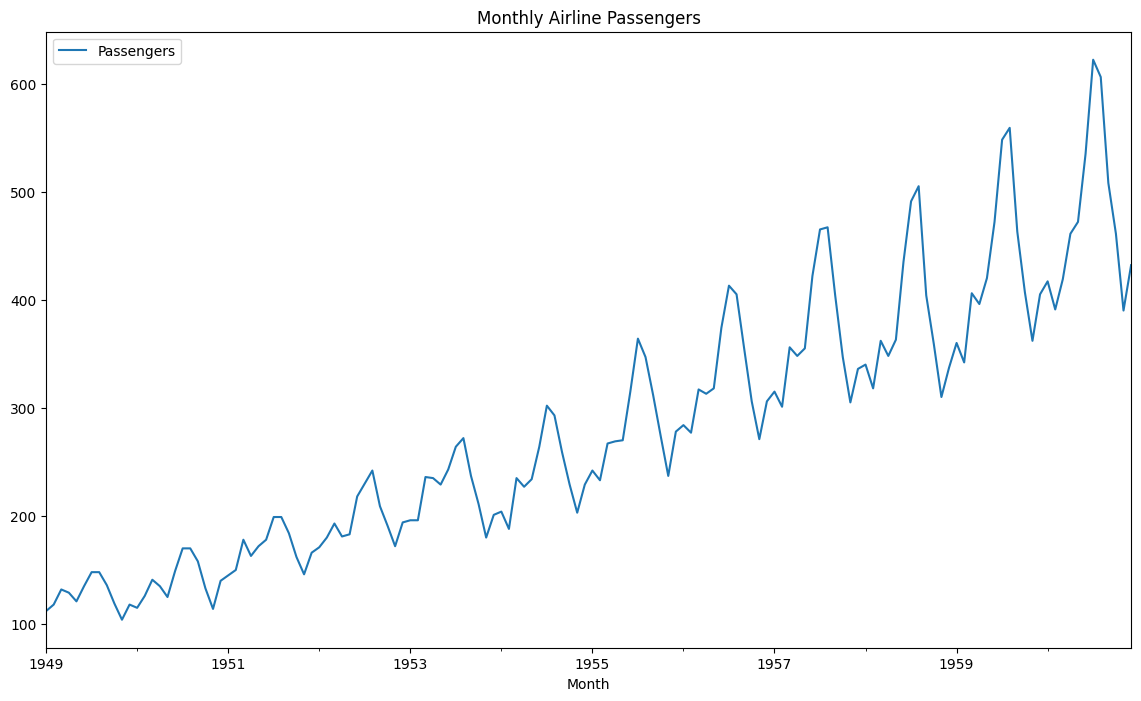

In [19]:
df.plot(figsize=(14, 8), title='Monthly Airline Passengers')

In [20]:
data = df.Passengers.values

In [21]:
data[:5]

array([112., 118., 132., 129., 121.])

In [22]:
type(data[:5])

numpy.ndarray

In [23]:
type(data[0])

numpy.float64

In [24]:
data = data.astype('float32')

In [25]:
type(data[0])

numpy.float32

In [26]:
data.shape

(144,)

In [27]:
data = data.reshape(-1, 1)

In [28]:
data.shape

(144, 1)

In [29]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [30]:
train, test, position = split_data(data, 0.33)

In [31]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [32]:
scaler_train = MinMaxScaler(feature_range=(0, 1))

In [33]:
train = scaler_train.fit_transform(train)

In [34]:
scaler_test = MinMaxScaler(feature_range=(0, 1))

In [35]:
test = scaler_test.fit_transform(test)

In [36]:
train[:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [37]:
test[:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [38]:
def create_feature(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        Y.append(data[i, 0])

    return np.array(X), np.array(Y)

In time series, the value of the series at time T is most affected by the T-1 time period. For this, we divide our data into time intervals at time T and values in the time period at time T-1.

In [39]:
# Train Dataset
X_train, y_train = create_feature(train, 1)

In [40]:
# Test Dataset
X_test, y_test = create_feature(test, 1)

In [41]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [42]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [43]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [44]:
y_train = y_train.reshape(-1, 1)

In [45]:
y_test = y_test.reshape(-1, 1)

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


We need to shape the RNN into the shape it wants before sending it to the neural network. Because RNN wants the data in 3 dimensions.

# **4) Modelling**

In [47]:
model = Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], 1)))

# One layer to Prevent Overlearning

model.add(Dropout(0.2))

# Output layer

model.add(Dense(1)) # means there will be an output consisting of 1 neuron

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Setting Optimization and Evaluation Metrics

model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]

EarlyStopping
> It is one of the methods used to prevent overlearning in neural networks.

> It is used to prevent the mdoel from overlearning by focusing on the changes between the train set and the valudation set. Loss in the Validation set drops to a certain extent with the train set, then the Validation set starts to drop after a certain point, and this is where EarlySropping comes into play and prevents overlearning.

     > patience

       > It refers to the period when education will be stopped and there will be no recovery.

     > verbose

       > It refers to the reporting method of the transaction here.

     >mode

     > A parameter relevant to tracking the development of the model
    
     > Training stops when the amount we monitor in min mode stops decreasing. At max, this is the opposite, when it stops increasing, training stops. In automatic mode, the direction to go is automatically subtracted after the tracked amount.

In [51]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,   # Refers to the size of data groups
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/50
78/95 [=======================>......] - ETA: 0s - loss: 0.0056
Epoch 1: val_loss improved from inf to 0.02687, saving model to mymodel.h5
95/95 [==============================] - 4s 7ms/step - loss: 0.0061 - val_loss: 0.0269
Epoch 2/50
81/95 [========================>.....] - ETA: 0s - loss: 0.0105
Epoch 2: val_loss improved from 0.02687 to 0.02389, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0239
Epoch 3/50
93/95 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 3: val_loss improved from 0.02389 to 0.02347, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0235
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.0113
Epoch 4: val_loss improved from 0.02347 to 0.02258, saving model to mymodel.h5
95/95 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0226
Epoch 5/50
78/95 [======================

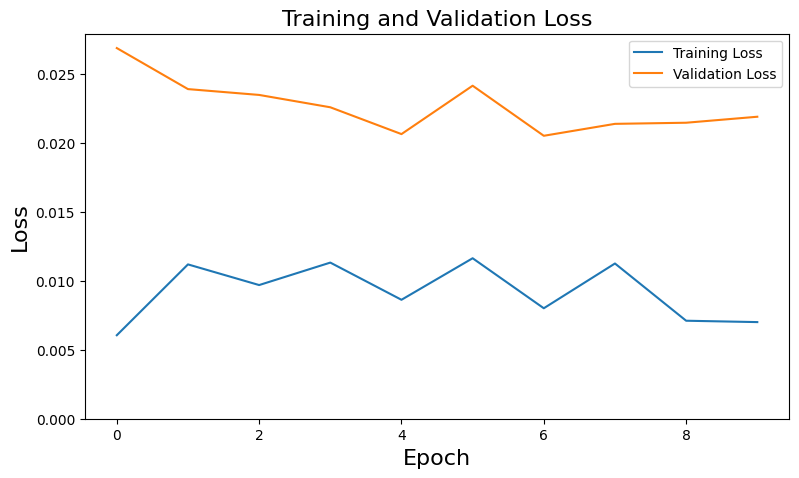

In [52]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()


# **5) Evulation**

In [53]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest Loss: %.1f%%" % (100.0 * loss))

47/47 [==============================] - 0s 2ms/step - loss: 0.0219

Test Loss: 2.2%


In [54]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 4ms/step


In [55]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 33ms/step


In [56]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [57]:
# RMSE Value of Train Data Set

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [58]:
# RMSE Value of Test Data Set

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [59]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 232.62867736816406
Test RMSE: 430.11956787109375


In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0
